# Asset Pricing 2: Homework 1

### Trent Potter

### Winter 2025

---

### Outline

#### Data

- `StockPortfolios.csv`: monthly stock returns of 30 portfolios from 1963-10 to 2013-12
- `FFMktFct.csv`: monthly broad market returns and tbills returns of 30 portfolios from 1963-10 to 2016-07

#### Problem 1: Estimating an SDF with the Market Factor

**Estimation Procedures**

Calculate SDF parameters ($b$ and $µ_F$), standard errors, $\chi^2$-statistics, and HJ-distance under three difference cases:

- **Assumption IID**: Equivalent to timeseries regression.
- **First-stage GMM**: Using $W=I$ weight matrix.
- **Two-step GMM**: Using optimal $W=S^{-1}$ weight matrix.

#### Problem 2: Principal Component Factors in the SDF

**Estimation Procedures**

Compute the first five principal components of the 30 portfolio excess returns, then re-run the above analysis.

- **Assumption IID**: Equivalent to timeseries regression.
- **First-stage GMM**: Using $W=I$ weight matrix.
- **Two-step GMM**: Attempt optimal $W=S^{-1}$ weight matrix.
  - Investigating invertibility of $S$ matrix
  - Using pseudo-inverse of $S$
  - Without $K$ pricing factor moment conditions

---

Known problems:

- class derived analytical matrix differs from numerical and self-derived version
- $J \sim \chi^2$ tests failing to reject strongly in every case, but they're very similar across methods. Given the variation in the models and the magnitudes of errors, I'd expect to reject, but I haven't yet found the bug.
- $S$ in the PCA case is invertible without fixes for linear dependence between the test assets and the factors! Again, I haven't yet found the bug.


In [55]:
import pandas as pd
import numpy as np
from numpy.linalg import inv as inv
from numpy.linalg import pinv as pinv
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
import seaborn as sns

display(
    HTML(
        '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
    )
)
pd.set_option("display.float_format", lambda x: "%.4g" % x)
np.set_printoptions(formatter={'float': '{:0.4g}'.format})


In [56]:
# Read in the CSV files
stock_portfolios = pd.read_csv(
    "StockPortfolios.csv", index_col=0, parse_dates=True, date_format="%Y%m"
)
ff_mkt_fct = pd.read_csv(
    "FFMktFct.csv", index_col=0, parse_dates=True, date_format="%Y%m"
)

# Truncate ff_mkt_fct to the same time period as stock_portfolios
ff_mkt_fct = ff_mkt_fct.loc[:"2013-12"]

# Concatenate the two dataframes along the column axis
Z = pd.concat([stock_portfolios / 100, ff_mkt_fct], axis=1)

# Subtract the "Tbill" column from every other column
for column in Z.columns:
    if column != "Tbill":
        Z[column] = Z[column] - Z["Tbill"]
Z.drop("Tbill", axis=1, inplace=True)

display(Z)

,Size_Short,Size_Long,GrossProfitability_Short,GrossProfitability_Long,Value_Short,Value_Long,ValProf_Short,ValProf_Long,Accruals_Short,Accruals_Long,...,ValMom_Long,IdiosyncraticVolatility_Short,IdiosyncraticVolatility_Long,Momentum_Short,Momentum_Long,LongRunReversals_Short,LongRunReversals_Long,BetaArbitrage_Short,BetaArbitrage_Long,Rmarket
1963-10-01,0.03246,0.002461,-0.004584,0.009868,0.03659,0.002359,-0.0127,0.01289,7.429e-05,0.1088,...,0.009235,0.01134,0.03759,0.01742,0.04974,0.03161,-0.0006856,0.01989,-0.006622,0.0253
1963-11-01,-0.008222,-0.02381,-0.005876,-0.01746,-0.001547,0.006253,-0.01127,-0.002491,-0.01423,-0.04634,...,0.0151,-0.02645,0.01006,-0.002067,-0.003162,0.01066,0.001016,-0.01538,-0.0146,-0.0085
1963-12-01,0.02297,-0.02587,0.01979,0.002957,0.02463,0.03433,0.02192,-0.01605,0.008949,0.01478,...,0.03838,-0.006328,0.02018,-0.02723,0.003959,0.0117,-0.00866,0.001978,0.01392,0.0183
1964-01-01,0.02817,0.04091,0.01566,0.008502,0.0261,0.02587,0.01385,0.02482,0.03616,0.03235,...,0.03617,-0.01791,0.03417,0.01455,0.01404,0.01806,0.04263,0.01699,0.01087,0.0224
1964-02-01,0.01206,0.02459,0.009282,0.01538,0.0193,0.05868,0.008917,0.0428,0.01436,0.02208,...,0.04577,0.01396,0.009185,0.01762,0.03215,0.01586,0.02582,0.01383,0.01134,0.0154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,-0.02816,-0.02845,-0.02922,-0.02792,-0.0204,-0.03674,-0.01778,-0.02775,-0.01726,-0.004716,...,-0.04689,0.006658,-0.04427,0.03006,-0.02701,-0.009481,-0.04152,-0.02106,-0.042,-0.0271
2013-09-01,0.02964,0.06403,0.02741,0.0584,0.06261,0.02387,0.06728,0.07928,0.0649,0.07164,...,0.02544,0.08317,0.01995,0.005207,0.07403,0.04367,0.02661,0.07844,0.01596,0.0377
2013-10-01,0.04755,0.01944,0.01516,0.03982,0.03805,0.0323,0.02717,0.05668,0.01537,0.0414,...,0.03487,-0.01089,0.04661,0.05121,0.02363,0.04619,0.02999,0.01729,0.04649,0.0418
2013-11-01,0.03378,0.05443,-0.006936,0.02184,0.02606,0.05342,0.0269,0.01982,0.03113,0.0234,...,0.05049,0.0282,0.03473,0.03206,0.03351,0.04133,0.07299,0.04414,0.03031,0.0312


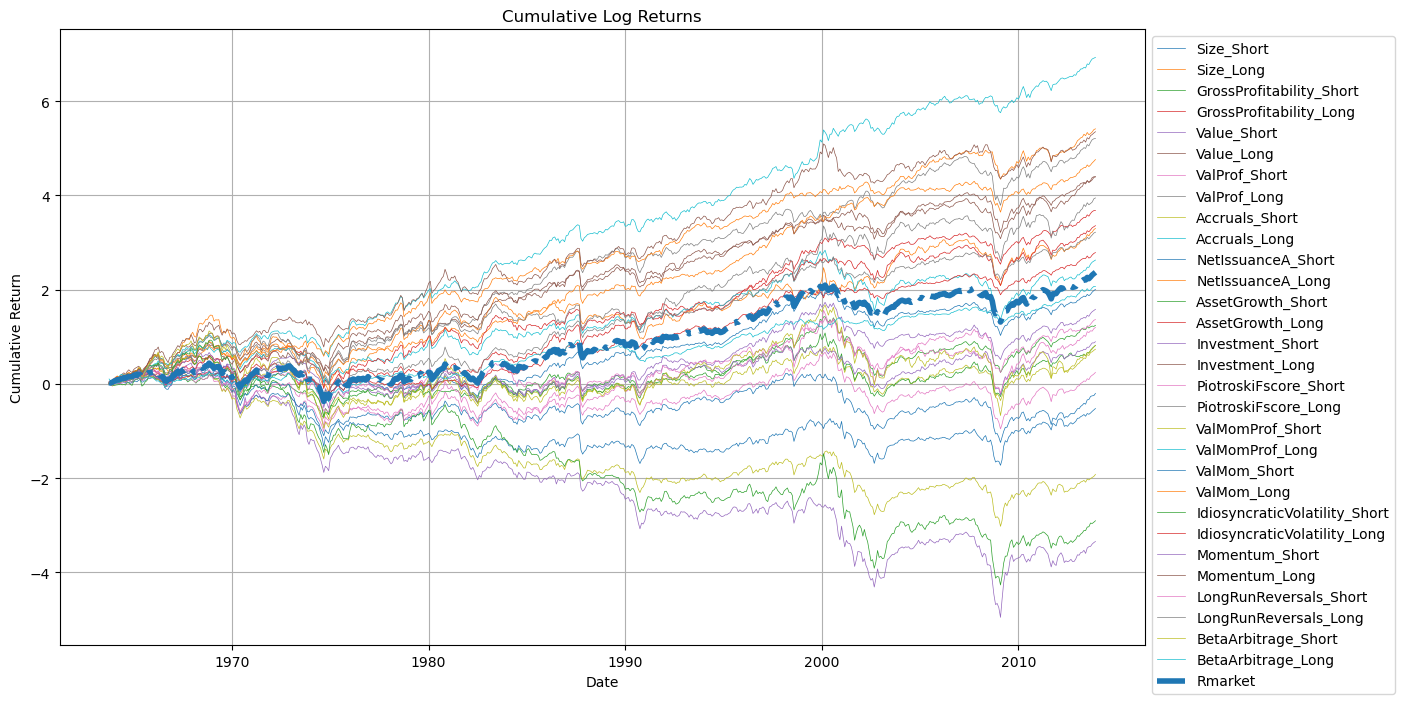

In [57]:
# Calculate cumulative returns
cumulative_log_returns = np.log((1 + Z).cumprod())

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for column in cumulative_log_returns.columns:
    if column == "Rmarket":
        plt.plot(
            cumulative_log_returns.index,
            cumulative_log_returns[column],
            label=column,
            linewidth=4,
            linestyle="-.",
        )
    else:
        plt.plot(
            cumulative_log_returns.index,
            cumulative_log_returns[column],
            label=column,
            linewidth=0.5,
        )

# Add legend
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Log Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# Problem 1 - SDF Estimation w/ Market Factor


In [58]:
# Market Factor
F = Z["Rmarket"]
F = F.to_numpy().reshape(-1, 1)
Z = Z.iloc[:, :-1].reset_index(drop=True)

T = Z.shape[0]
N = Z.shape[1]

In [59]:
def approach_1_ols(F: np.ndarray, Z: np.ndarray):
    T = Z.shape[0]
    N = Z.shape[1]
    
    # Approach 1, with matrix OLS interpretation
    beta = inv(F.T @ F) @ F.T @ Z
    alpha = (Z.reset_index(drop=True) - (beta.T @ F.T).T).mean()
    factor_cov = F.T @ F / T
    mu_hat = F.mean(axis=0).reshape(-1, 1)
    b_hat = inv(factor_cov) @ mu_hat
    theta_hat_iid = np.vstack((b_hat.flatten(), mu_hat.flatten()))

    # Errors
    epsilon = Z - (beta.T @ F.T).T
    epsilon_cov = epsilon.T @ epsilon
    square_sharpe = alpha.T @ inv(epsilon_cov) @ alpha

    # J test, Chi-squared with N-K -> 30 (Z) + 2 (factor px'ing & mean) - 2 (b & mu) = 30 DOF
    J = (
        T
        * alpha.T
        @ inv(epsilon_cov)
        @ alpha
        * inv(1 + mu_hat.T @ inv(factor_cov) @ mu_hat).item()
    )
    p_value = 1 - chi2.cdf(J, df=N)

    iid_result = pd.concat(
        [
            pd.Series(beta.T[0], index=Z.columns, name="beta"),
            pd.Series(alpha, index=Z.columns, name="alpha"),
        ],
        axis=1,
    )
    # Store the results in a dictionary
    results_dict = {
        "IID": {
            "b_hat": b_hat.flatten(),
            "mu_hat": mu_hat.flatten(),
            "J": J,
            "p_value": p_value,
            "square_sharpe": square_sharpe,
        }
    }
    return results_dict, theta_hat_iid, iid_result

# Example usage
q1_results, theta_hat_iid, iid_result = approach_1_ols(F, Z)

print(
    f""" {'='*30} IID Results {'='*30}
    b_hat: {q1_results['IID']['b_hat'][0]:0.5g}\tmu_hat: {q1_results['IID']['mu_hat'][0]:0.5g}
    J: {q1_results['IID']['J']:0.5g} Fail to reject null with p={q1_results['IID']['p_value']:0.5f}
    square_sharpe: {q1_results['IID']['square_sharpe']:0.5g}\n {'='*73} """
)
display(iid_result)

 ============================== IID Results ==============================
    b_hat: 2.4305	mu_hat: 0.0049582
    J: 0.2285 Fail to reject null with p=1.00000
    square_sharpe: 0.00038351


,beta,alpha
Size_Short,0.9278,-0.0003488
Size_Long,1.119,0.002026
GrossProfitability_Short,0.9438,-0.001464
GrossProfitability_Long,0.9393,0.002579
Value_Short,1.068,-0.001318
Value_Long,0.9947,0.003821
ValProf_Short,1.184,-0.003819
ValProf_Long,1.074,0.004962
Accruals_Short,1.258,-0.003076
Accruals_Long,1.126,0.0003594


In [60]:
# Approach 2 - 1st Stage GMM with Identity weighting matrix

# Define the moment conditions g : (N+2K x 1)
def moments(theta, X):
    F, Z = X
    b, mu = theta.reshape(-1, F.shape[1],1)
    m = (1 - (F - mu.T) @ b).T

    return np.hstack([
        m.T * Z,
        m.T * F,
        F - mu.T,
    ])


# Define the gradient matrix d = dg/dtheta : (N+2K x 2K)
def d_matrix(theta, X, class_approach=False):
    F, Z = X
    N = Z.shape[1]
    K = F.shape[1]
    b, mu = theta.reshape(-1, K)
    b = b.reshape(-1, 1) # K x 1
    mu = mu.reshape(-1, 1) # K x 1
    F_bar = np.mean(F, axis=0, keepdims=True)
    Z_bar = np.mean(Z, axis=0, keepdims=True)

    f_cov = np.cov(F.T, ddof=0).reshape(K, K)  # KxK
    beta = np.cov(Z,F,rowvar=False)[:N,N:N+K+1]@inv(f_cov) # N x K
    G = np.zeros((N + 2 * K, 2 * K))
    if not class_approach:  # self derived (unsure if correct)
        # Left K columns
        G[0:N, 0:K] = -Z.T @ (F - mu.T) / T             # Derivative of test pricing cond w.r.t b
        G[N : N + K, 0:K] = (-F.T @ (F - mu.T) / T)     # Derivative of factor pricing cond w.r.t b
        G[N + K : N + 2 * K, 0:K] = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b

        # Right K columns
        G[0:N, K : 2 * K] = Z_bar.T @ b.T               # Derivative of test pricing cond w.r.t mu
        G[N : N + K, K : 2 * K] = (F_bar.T @ b.T)       # Derivative of factor pricing cond w.r.t mu
        G[N + K : N + 2 * K, K : 2 * K] = -np.eye(K)  # Derivative of mean factor pricing cond w.r.t mu

    else:  # from the notes
        # Left K columns
        G[0:N, 0:K] = -beta @ f_cov                   # Derivative of test pricing cond w.r.t b
        G[N : N + K, 0:K] = -f_cov                    # Derivative of factor pricing cond w.r.t b
        G[N + K : N + 2 * K, 0:K] = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b

        # Right K columns
        G[0:N, K : 2 * K] = beta @ mu @ b.T           # Derivative of test pricing cond w.r.t mu
        G[N : N + K, K : 2 * K] = mu @ b.T            # Derivative of factor pricing cond w.r.t mu
        G[N + K : N + 2 * K, K : 2 * K] = -np.eye(K)  # Derivative of mean factor pricing cond w.r.t mu
    return 2*G  # N+2K x 2K


# GMM objective function
def gmm_objective_and_gradient(theta, X, W):
    # Compute the sample moments
    g = moments(theta, X).mean(axis=0)
    obj = g.T @ W @ g
    grad = d_matrix(theta, X).T @ W @ g
    return obj , grad 


# Initial weighting matrix (identity)

def solve_gmm_optimization(X,W, theta_hat) -> np.ndarray:
    gmm_result = minimize(
        fun=gmm_objective_and_gradient,
        x0=np.array(theta_hat.flatten()),  # Initial guess for theta
        args=(X, W),  # Data, weighting matrix, gradient function
        method="BFGS",
        jac=True,
        tol=1e-7,
    )
    return gmm_result.x.reshape(-1, F.shape[1])

def estimate_S(X, theta_hat, no_corr=False):
    g = moments(theta_hat, X)
    if no_corr:
        g_hat = g.mean(axis=0, keepdims=True)
        outer_products = np.array([np.outer(row, row) for row in g - g_hat])
        return outer_products.mean(axis=0)
    return(g.T @ g)/T

def solve_gmm_identity(X, theta_hat):
    F, Z = X
    N = Z.shape[1]
    K = F.shape[1]
    W = np.eye(N + 2 * K)
    theta_hat_gmm = solve_gmm_optimization(X, W, theta_hat)

    # Demean the errors and assume 0 serial correlation
    S_gmm_ind = estimate_S(X, theta_hat_gmm, no_corr=True)

    g = moments(theta_hat_gmm, X)
    J = g.mean(axis=0).T @ inv(S_gmm_ind) @ g.mean(axis=0)
    p_value = 1 - chi2.cdf(J, df=N)

    alpha = g.mean(axis=0)[:N]
    epsilon = g[:, :N]
    epsilon_cov = epsilon.T @ epsilon
    square_sharpe = alpha.T @ inv(epsilon_cov) @ alpha
    theta_hat_gmm = theta_hat_gmm.reshape(-1, F.shape[1])
    return {
        "b_hat": theta_hat_gmm[0],
        "mu_hat": theta_hat_gmm[1],
        "J": J,
        "p_value": p_value,
        "square_sharpe": square_sharpe,
    }
    
def solve_gmm_optimal(X, theta_hat, no_corr=False):
    F,Z = X
    # get params for 2nd stage GMM
    S_gmm_optimal = estimate_S(X, theta_hat, no_corr=no_corr)

    # 2nd Stage GMM with optimal weighting matrix
    theta_hat_gmm_opt = solve_gmm_optimization(X, inv(S_gmm_optimal), theta_hat)


    # Optimal S with serial correlation used in calculating J
    g=moments(theta_hat_gmm_opt, X)
    J = g.mean(axis=0).T @ inv(S_gmm_optimal) @ g.mean(axis=0)
    p_value = 1 - chi2.cdf(J, df=N)

    alpha = g.mean(axis=0)[:N]
    epsilon = g[:, :N]
    epsilon_cov = epsilon.T @ epsilon
    square_sharpe = alpha.T @ inv(epsilon_cov) @ alpha
    theta_hat_gmm_opt = theta_hat_gmm_opt.reshape(-1, F.shape[1])
    return{
                "b_hat": theta_hat_gmm_opt[0],
                "mu_hat": theta_hat_gmm_opt[1],
                "J": J,
                "p_value": p_value,
                "square_sharpe": square_sharpe,
    }

In [61]:
X = (F, Z.to_numpy())
q1_results["GMM_I"] = solve_gmm_identity(X, theta_hat_iid)

print(
    f""" {'='*30} GMM Stage 1 Results {'='*30}
    b_hat: {q1_results["GMM_I"]["b_hat"][0]:0.5g}\tmu_hat: {q1_results["GMM_I"]["mu_hat"][0]:0.5g}
    J: {q1_results["GMM_I"]["J"]:0.5g} \tFail to reject null with p={q1_results["GMM_I"]["p_value"]:0.5f}
    square_sharpe: {q1_results["GMM_I"]["square_sharpe"]:0.5g}\n {'='*81} """
)

 ============================== GMM Stage 1 Results ==============================
    b_hat: 2.1204	mu_hat: 0.0038252
    J: 0.30073 	Fail to reject null with p=1.00000
    square_sharpe: 0.00038021


In [62]:
# Approach 3 - 2nd Stage GMM with optimal weighting matrix

theta_hat_gmm = np.array([q1_results["GMM_I"]["b_hat"], q1_results["GMM_I"]["mu_hat"]])
q1_results["GMM_Opt"] = solve_gmm_optimal(X, theta_hat_gmm)
q1_results["GMM_Ind"] = solve_gmm_optimal(X, theta_hat_gmm, no_corr=True)

print(
    f""" {'='*30} GMM Stage 2 Results (with serial corr & mean error != 0){'='*30}
    b_hat: {q1_results["GMM_Opt"]["b_hat"][0]:0.5g}\tmu_hat: {q1_results["GMM_Opt"]["mu_hat"][0]:0.5g}
    J: {q1_results["GMM_Opt"]["J"]:0.5g} \tFail to reject null with p={q1_results["GMM_Opt"]["p_value"]:0.5f}
    square_sharpe: {q1_results["GMM_Opt"]["square_sharpe"]:0.5g}\n {'='*117} """
)


print(
    f""" {'='*29} GMM Stage 2 Results (with no serial corr & de-meaned error){'='*28}
    b_hat: {q1_results["GMM_Ind"]["b_hat"][0]:0.5g}\tmu_hat: {q1_results["GMM_Ind"]["mu_hat"][0]:0.5g}
    J: {q1_results["GMM_Ind"]["J"]:0.5g} \t Fail to reject null with p={q1_results["GMM_Ind"]["p_value"]:0.5f}
    square_sharpe: {q1_results["GMM_Ind"]["square_sharpe"]:0.5g}\n {'='*117} """
)

 ============================== GMM Stage 2 Results (with serial corr & mean error != 0)==============================
    b_hat: 2.4521	mu_hat: 0.0047274
    J: 0.22928 	Fail to reject null with p=1.00000
    square_sharpe: 0.0003768
 ============================= GMM Stage 2 Results (with no serial corr & de-meaned error)============================
    b_hat: 2.505	mu_hat: 0.0049084
    J: 0.29755 	 Fail to reject null with p=1.00000
    square_sharpe: 0.00037627


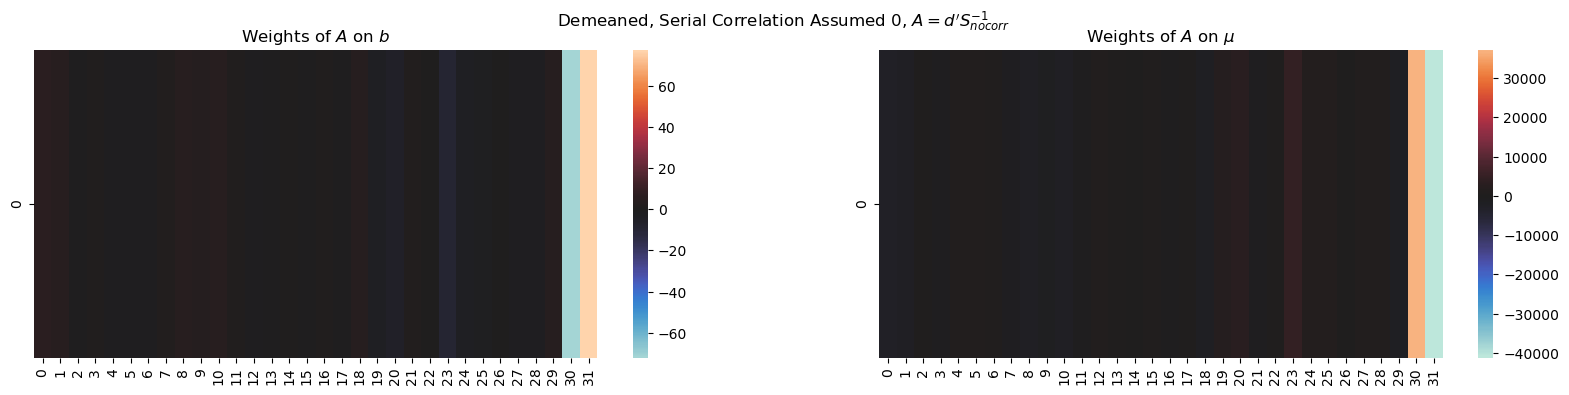

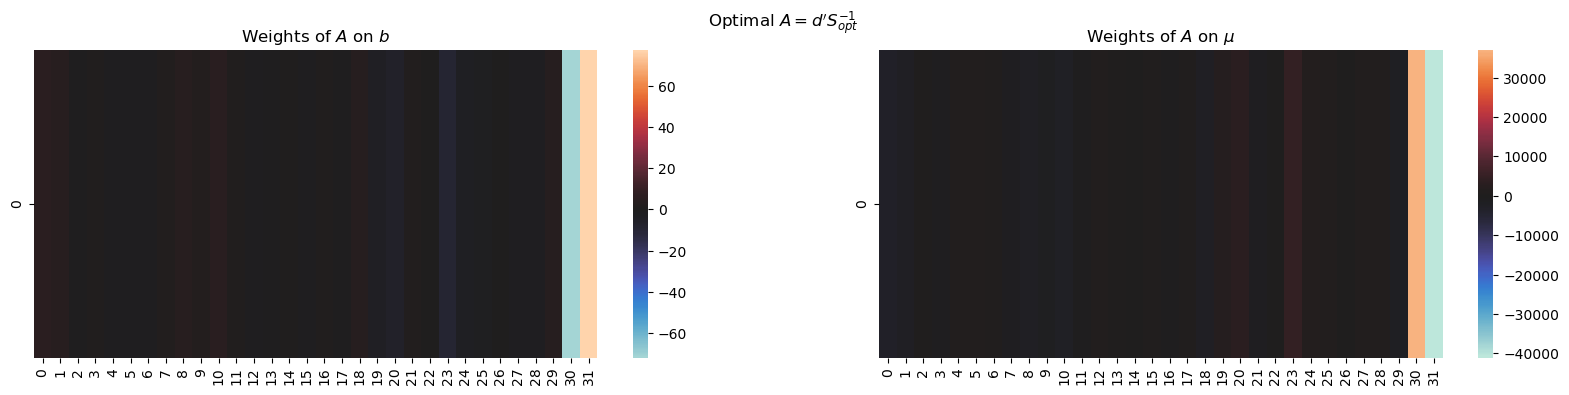

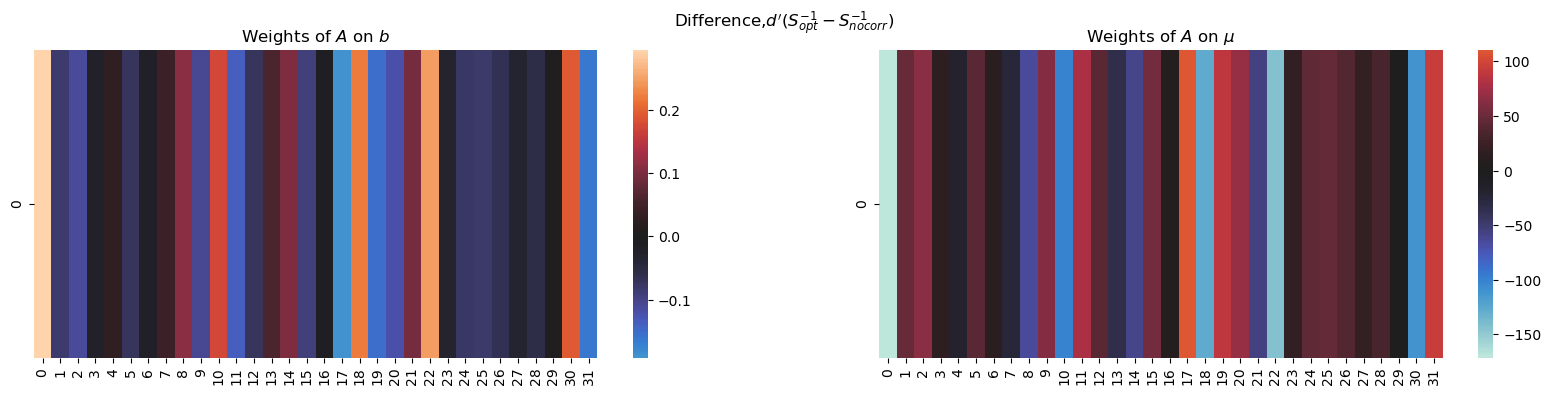

In [63]:
# Show differences, though minimal in A when allowing for serial correlation and non-zero mean error
d_analytical = d_matrix(theta_hat_gmm, X)
def plot_cov(S, title=""):
  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(20, 4))
  fig.suptitle(title)
  # Plot the first row of S
  sns.heatmap(S[0].reshape(1, -1), ax=axes[0], cmap="icefire", center=0)
  axes[0].set_title(r"Weights of $A$ on $b$")

  # Plot the second row of S
  sns.heatmap(S[1].reshape(1, -1), ax=axes[1], cmap="icefire", center=0)
  axes[1].set_title(r"Weights of $A$ on $\mu$")
  plt.show()

theta_hat_gmm = np.array([q1_results["GMM_I"]["b_hat"], q1_results["GMM_I"]["mu_hat"]])
S_gmm_optimal = estimate_S(X, theta_hat_gmm)
S_gmm_ind = estimate_S(X, theta_hat_gmm, no_corr=True)

# Plot differences in the weighting matrix used for GMM
plot_cov(d_analytical.T@inv(S_gmm_ind), "Demeaned, Serial Correlation Assumed 0, $A=d'S_{no corr}^{-1}$")
plot_cov(d_analytical.T@inv(S_gmm_optimal), "Optimal $A=d'S_{opt}^{-1}$")
plot_cov(d_analytical.T@(inv(S_gmm_optimal) - inv(S_gmm_ind)), "Difference,$d'(S_{opt}^{-1}-S_{no corr}^{-1})$")

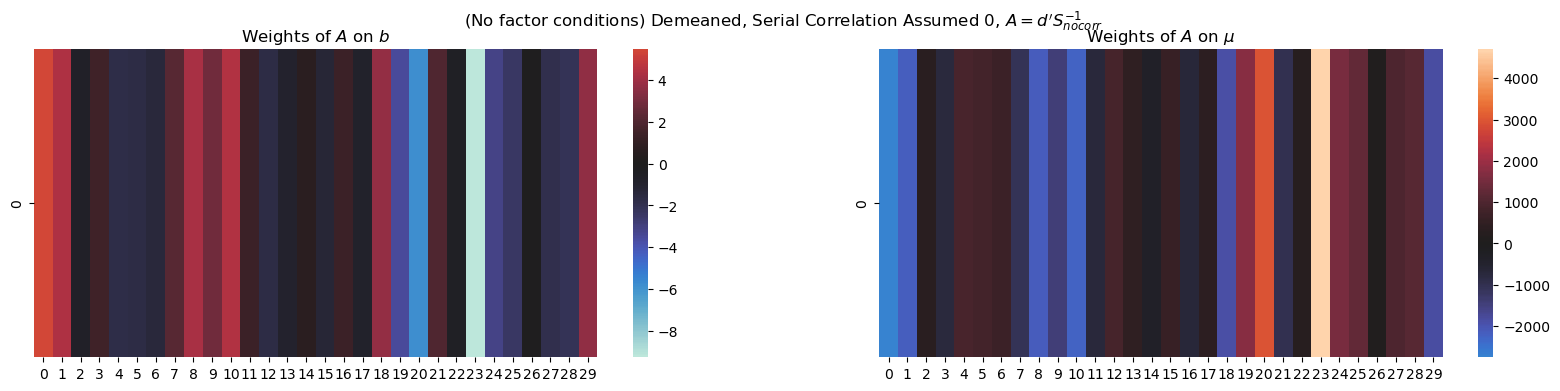

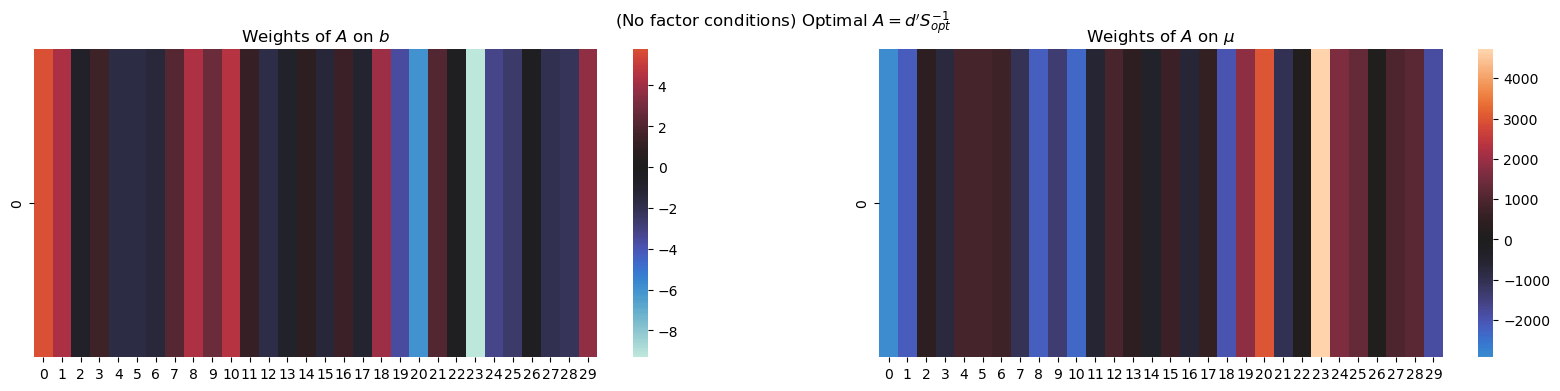

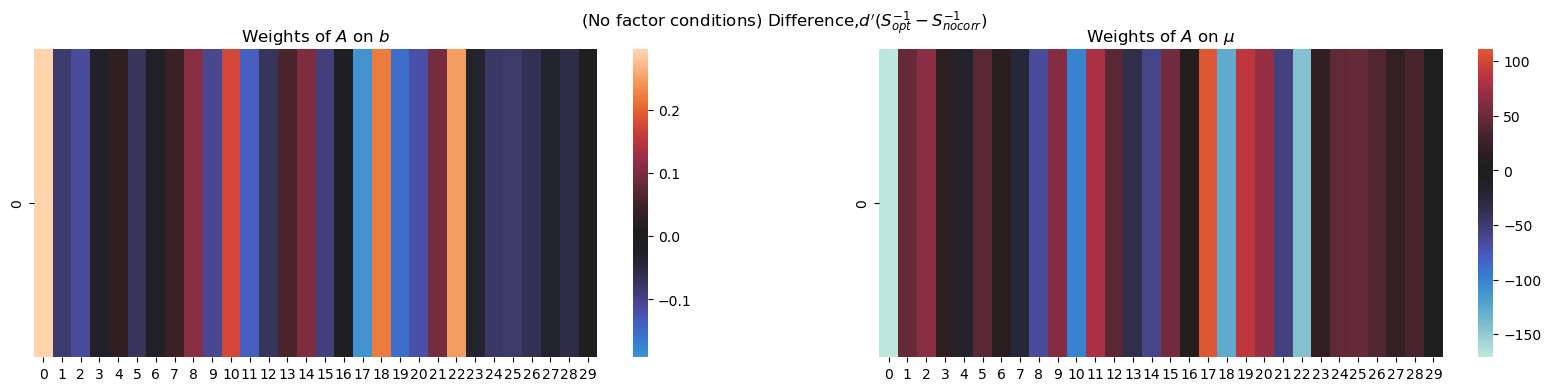

In [64]:
# Ignore the heavily weighted factor pricing & factor mean conditions
plot_cov((d_analytical.T@inv(S_gmm_ind))[:,:-2], "(No factor conditions) Demeaned, Serial Correlation Assumed 0, $A=d'S_{no corr}^{-1}$")
plot_cov((d_analytical.T@inv(S_gmm_optimal))[:,:-2], "(No factor conditions) Optimal $A=d'S_{opt}^{-1}$")
plot_cov((d_analytical.T@(inv(S_gmm_optimal) - inv(S_gmm_ind)))[:,:-2], "(No factor conditions) Difference,$d'(S_{opt}^{-1}-S_{no corr}^{-1})$")

In [65]:
#Summary of Results
q1_results_df = pd.DataFrame(q1_results)
q1_results_df.loc[:"mu_hat"] = q1_results_df.loc[:"mu_hat"].map(lambda x: x[0])
q1_results_df

,IID,GMM_I,GMM_Opt,GMM_Ind
b_hat,2.43,2.12,2.452,2.505
mu_hat,0.004958,0.003825,0.004727,0.004908
J,0.2285,0.3007,0.2293,0.2975
p_value,1,1,1,1
square_sharpe,0.0003835,0.0003802,0.0003768,0.0003763


# Q1 Analysis

### Results

We find that the IID assumption case is very similar to the 2nd stage GMM cases (whether we impose no serial corr + 0 errors or not). This result makes sense upon analysis of the resulting $A$ matrices and the relatively small weights associated with the test asset pricing conditions. Interestingly, allowing for non-zero weights on the test assets via the 3 GMM doesn't significantly reduce the unexplained square sharpe.

### Allowing for non-zero correlation and $\hat{g}(\theta) \neq 0$ in $S$ estimation

We can note that introducing serial correlation & non-zero error means in the optimal weighting matrix has minor effect reducing the weight on the test pricing conditions (i.e. the pricing condition weights are closer to 0 in $S_{opt}^{-1}$ than in $S_{no corr}^{-1}$). This drives the optimal GMM to more closely mimic the IID assumption results assuming there's no additional pricing information to be found in the test assets, but the effect is small relative to the changes found in the factor pricing and factor mean conditions which dominate.

In both the conventional optimal $S_{opt}$ and no-corr, de-meaned errors, $S_{no corr}$, we find what looks to be offseting, large magnitude weights on the factor pricing error and factor mean errors. These weights are an order of magnitude larger than the largest test-asset pricing conditions.

### Failing to reject with $J \sim \chi^2_N$

We're failing to reject, strongly, of the null that there are 0 pricing errors in all cases. This interpretation makes little sense to me, but I'm not sure yet if there's something I'm missing conceptually or a bug in the code.


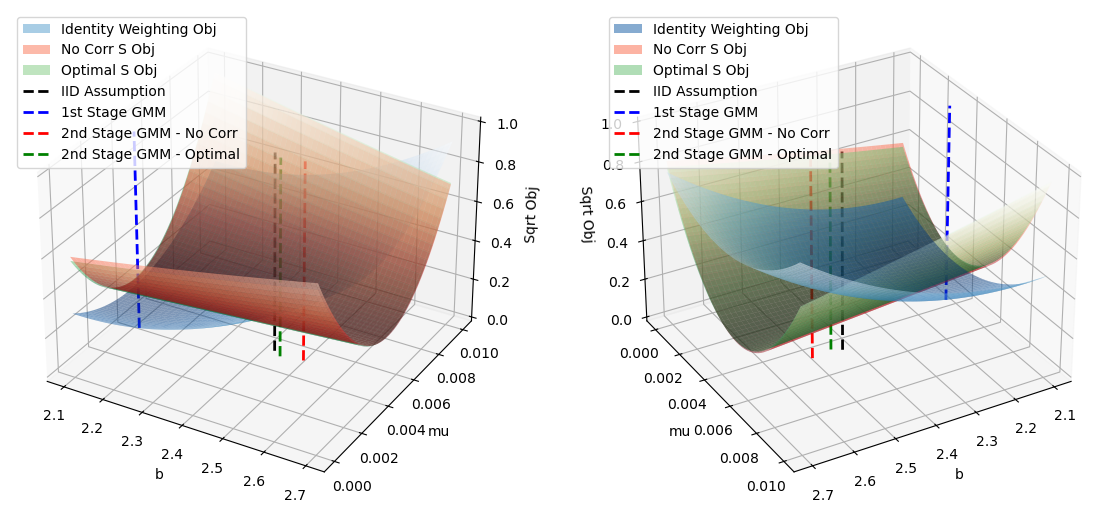

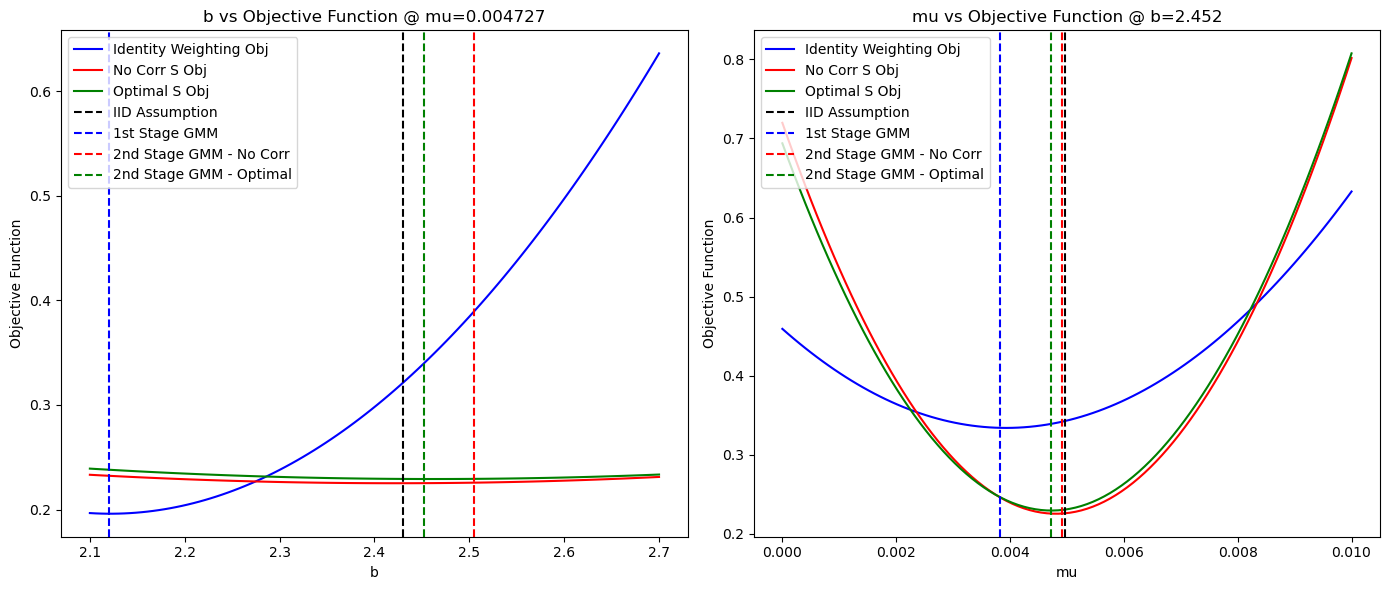

In [66]:
# Plots of theta_hat versus objective function defined by choice of weighting matrix
# Define the range for mu and b
b_range = np.linspace(2.1, 2.7, 100)
mu_range = np.linspace(0, 0.01, 100)
S_optimal_inv = inv(S_gmm_optimal)
S_ind_inv = inv(S_gmm_ind)
W = np.eye(N + 2 * F.shape[1])
theta_hat_gmm_ind = q1_results["GMM_Ind"]["b_hat"][0], q1_results["GMM_Ind"]["mu_hat"][0]
theta_hat_gmm_opt = q1_results["GMM_Opt"]["b_hat"][0], q1_results["GMM_Opt"]["mu_hat"][0]

# Create a meshgrid for mu and b
b_grid, mu_grid = np.meshgrid(b_range, mu_range)

# Calculate the GMM objective function for each pair of (mu, b)
def get_objective_grid(b_grid, mu_grid, X, W):
    obj_values = np.array(
        [
            gmm_objective_and_gradient(np.array([b, mu]), X, W)[0]
            for b, mu in zip(np.ravel(b_grid), np.ravel(mu_grid))
        ]
    )
    return obj_values.reshape(mu_grid.shape)

optimal_obj_grid = get_objective_grid(b_grid, mu_grid, X, S_optimal_inv)

# Positive affine rescale to make comparable to optimal_obj_grid
no_corr_obj_grid = get_objective_grid(b_grid, mu_grid, X, S_ind_inv)
no_corr_obj_grid = no_corr_obj_grid / (no_corr_obj_grid.max() - no_corr_obj_grid.min()) * (optimal_obj_grid.max() - optimal_obj_grid.min())
no_corr_obj_grid = no_corr_obj_grid - no_corr_obj_grid.mean() + optimal_obj_grid.mean()
identity_obj_grid = get_objective_grid(b_grid, mu_grid, X, W)
identity_obj_grid = identity_obj_grid / (identity_obj_grid.max() - identity_obj_grid.min()) * (optimal_obj_grid.max()-optimal_obj_grid.min())
identity_obj_grid = identity_obj_grid - identity_obj_grid.mean() + optimal_obj_grid.mean()
def add_theta_line(ax, theta_hat, color, label):
    ax.plot([theta_hat[0]], [theta_hat[1]], [0, 1], color=color, linestyle="--", linewidth=2, label=label)

def add_objective_surface(ax, obj_grid, color, label):
    ax.plot_surface(b_grid, mu_grid, obj_grid, cmap=color, alpha=0.5, label=label)
    ax.set_xlabel("b")
    ax.set_ylabel("mu")
    ax.set_zlabel("Sqrt Obj")
    
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(121, projection="3d")
add_objective_surface(ax1, identity_obj_grid, "Blues_r", "Identity Weighting Obj")
add_objective_surface(ax1, no_corr_obj_grid, "Reds_r", "No Corr S Obj")
add_objective_surface(ax1, optimal_obj_grid, "Greens_r", "Optimal S Obj")
add_theta_line(ax1, theta_hat_iid, "black", "IID Assumption")
add_theta_line(ax1, theta_hat_gmm, "blue", "1st Stage GMM")
add_theta_line(ax1, theta_hat_gmm_ind, "red", "2nd Stage GMM - No Corr")
add_theta_line(ax1, theta_hat_gmm_opt, "green", "2nd Stage GMM - Optimal")
ax1.legend(loc="upper left")

ax2 = fig.add_subplot(122, projection="3d")
add_objective_surface(ax2, identity_obj_grid, "Blues_r", "Identity Weighting Obj")
add_objective_surface(ax2, no_corr_obj_grid, "Reds_r", "No Corr S Obj")
add_objective_surface(ax2, optimal_obj_grid, "Greens_r", "Optimal S Obj")
add_theta_line(ax2, theta_hat_iid, "black", "IID Assumption")
add_theta_line(ax2, theta_hat_gmm, "blue", "1st Stage GMM")
add_theta_line(ax2, theta_hat_gmm_ind, "red", "2nd Stage GMM - No Corr")
add_theta_line(ax2, theta_hat_gmm_opt, "green", "2nd Stage GMM - Optimal")
ax2.view_init(elev=30, azim=60)  # Change the view angle
ax2.legend(loc="upper left")

# 2D Subplots for b and mu vs Objective Function
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Plot b vs Objective Function @ mu_hat from Optimal GMM
mu_idx = (np.abs(mu_range - theta_hat_gmm_opt[1])).argmin()
ax3.plot(b_range, identity_obj_grid[mu_idx, :], label="Identity Weighting Obj", color="blue")
ax3.plot(b_range, no_corr_obj_grid[mu_idx, :], label="No Corr S Obj", color="red")
ax3.plot(b_range, optimal_obj_grid[mu_idx, :], label="Optimal S Obj", color="green")
ax3.axvline(x=theta_hat_iid[0], color="black", linestyle="--", label="IID Assumption")
ax3.axvline(x=theta_hat_gmm[0], color="blue", linestyle="--", label="1st Stage GMM")
ax3.axvline(x=theta_hat_gmm_ind[0], color="red", linestyle="--", label="2nd Stage GMM - No Corr")
ax3.axvline(x=theta_hat_gmm_opt[0], color="green", linestyle="--", label="2nd Stage GMM - Optimal")
ax3.set_xlabel("b")
ax3.set_ylabel("Objective Function")
ax3.legend(loc="upper left")
ax3.set_title(f"b vs Objective Function @ mu={theta_hat_gmm_opt[1]:.4g}")

# Plot mu vs Objective Function @b_hat from Optimal GMM
b_idx = (np.abs(b_range - theta_hat_gmm_opt[0])).argmin()
ax4.plot(mu_range, identity_obj_grid[:, b_idx], label="Identity Weighting Obj", color="blue")
ax4.plot(mu_range, no_corr_obj_grid[:, b_idx], label="No Corr S Obj", color="red")
ax4.plot(mu_range, optimal_obj_grid[:, b_idx], label="Optimal S Obj", color="green")
ax4.axvline(x=theta_hat_iid[1], color="black", linestyle="--", label="IID Assumption")
ax4.axvline(x=theta_hat_gmm[1], color="blue", linestyle="--", label="1st Stage GMM")
ax4.axvline(x=theta_hat_gmm_ind[1], color="red", linestyle="--", label="2nd Stage GMM - No Corr")
ax4.axvline(x=theta_hat_gmm_opt[1], color="green", linestyle="--", label="2nd Stage GMM - Optimal")
ax4.set_xlabel("mu")
ax4.set_ylabel("Objective Function")
ax4.legend(loc="upper left")
ax4.set_title(f"mu vs Objective Function @ b={theta_hat_gmm_opt[0]:.4g}")
plt.tight_layout()
plt.show()

In [67]:
##### Numerical Vs Analytical Gradient Debug #####
# when using the class approach, the d_matrix is 
# different from the self derived one & the numerical gradient, namely in the d(mz)/dmu component
from scipy.optimize import approx_fprime
test_theta = theta_hat_iid.flatten()

# Compute the numerical gradient, and analytical gradient 2 ways
d_analytical = d_matrix(test_theta, X)
d_analytical_class = d_matrix(test_theta, X, class_approach=True)

grad_numerical = approx_fprime(test_theta, lambda t: gmm_objective_and_gradient(t, X, W)[0], 1e-10)
grad_analytical_class = (d_analytical_class.T @ W @ moments(test_theta, X).mean(axis=0))
grad_analytical = (d_analytical.T @ W @ moments(test_theta, X).mean(axis=0))

# Compare the gradients
print("Numerical Gradient:", grad_numerical)
print("Analytical Gradient (class notes):", grad_analytical_class)
print("Analytical Gradient (self derived):", grad_analytical)
print("Difference (d_analytical - d_class):\n", (d_analytical - d_analytical_class).round(4))

# Seeing difference in the d(mz)/dmu component of d_matrix

Numerical Gradient: [0.0001007 0.002091]
Analytical Gradient (class notes): [0.0001008 -0.0006028]
Analytical Gradient (self derived): [0.0001007 0.002091]
Difference (d_analytical - d_class):
 [[0 -0.0018]
 [0 0.0099]
 [0 -0.0072]
 [0 0.0126]
 [0 -0.0065]
 [0 0.0188]
 [0 -0.0188]
 [0 0.0244]
 [0 -0.0152]
 [0 0.0017]
 [0 -0.022]
 [0 0.0211]
 [0 -0.0148]
 [0 0.0082]
 [0 -0.0133]
 [0 0.0164]
 [0 -0.0094]
 [0 0.0078]
 [0 -0.0359]
 [0 0.0391]
 [0 -0.0238]
 [0 0.0273]
 [0 -0.0434]
 [0 0.0088]
 [0 -0.0463]
 [0 0.0245]
 [0 -0.01]
 [0 0.0131]
 [0 -0.0169]
 [0 0.007]
 [0 0]
 [0 0]]


# Problem 2 - SDF Estimation with Test Asset PCA


In [160]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(Z)
# Extract the principal components
principal_components = pca.components_[:5]
eigen_values = pca.explained_variance_[:5]
explained_variance_fractions = pca.explained_variance_ratio_
F_pc = ((Z-Z.mean(axis=0))@principal_components.T).to_numpy()
F_pc_2 = pca.transform(Z)


In [161]:
F_pc.mean(axis=0)

array([9.896e-19, 2.232e-18, -2.929e-18, 1.648e-18, 5.293e-19])

In [162]:
F_pc - F_pc_2

array([[2.776e-17, 0, -6.939e-18, 3.469e-18, 4.337e-19],
       [-1.388e-17, 0, 0, 0, -1.735e-18],
       [1.041e-17, 0, 0, 1.388e-17, 0],
       ...,
       [2.776e-17, 1.388e-17, -2.082e-17, 1.388e-17, -1.388e-17],
       [5.551e-17, 1.041e-17, 0, 6.939e-18, 6.939e-18],
       [2.776e-17, -1.388e-17, -6.939e-18, 0, 3.469e-18]])

In [171]:
# Generate the covariance matrix of Z
cov_matrix = np.cov(Z, rowvar=False)

# Perform SVD on the covariance matrix
U, S, Vt = np.linalg.svd((Z - Z.mean(axis=0)).T)


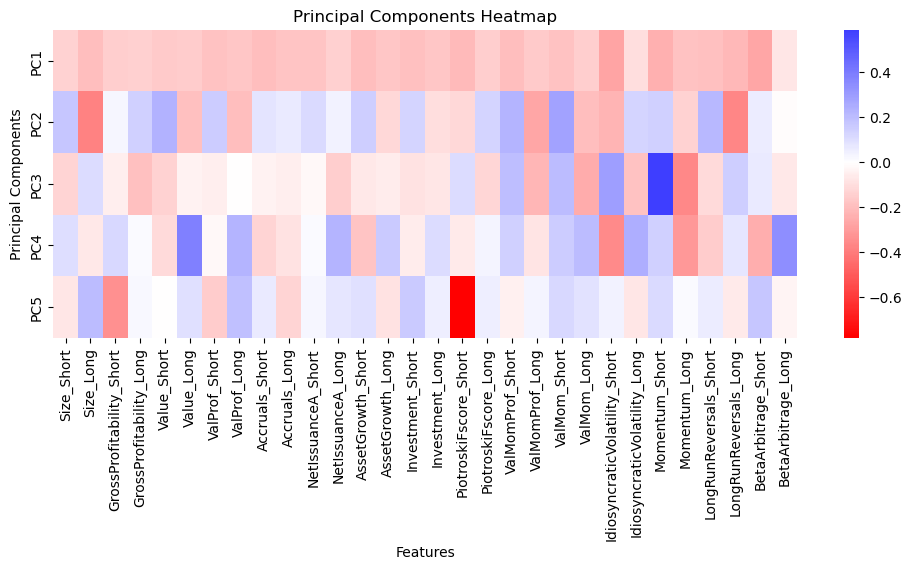

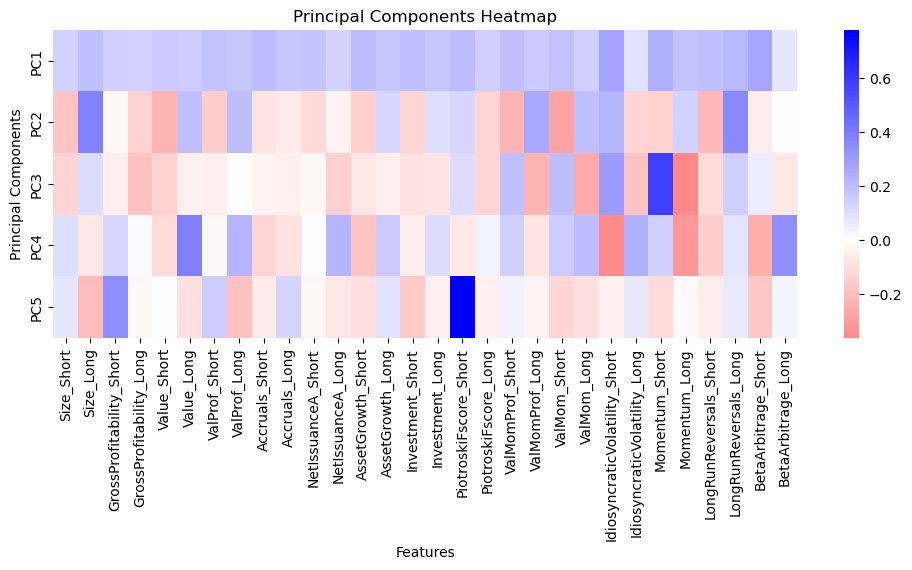

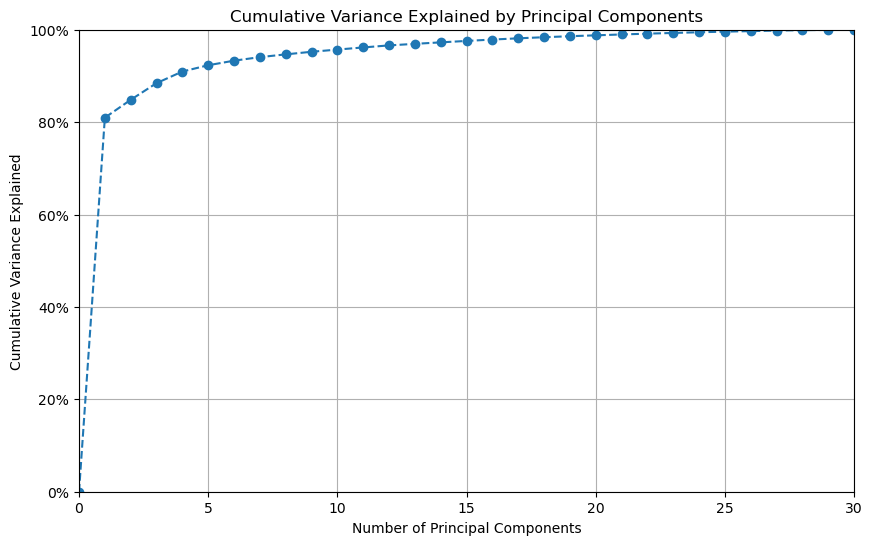

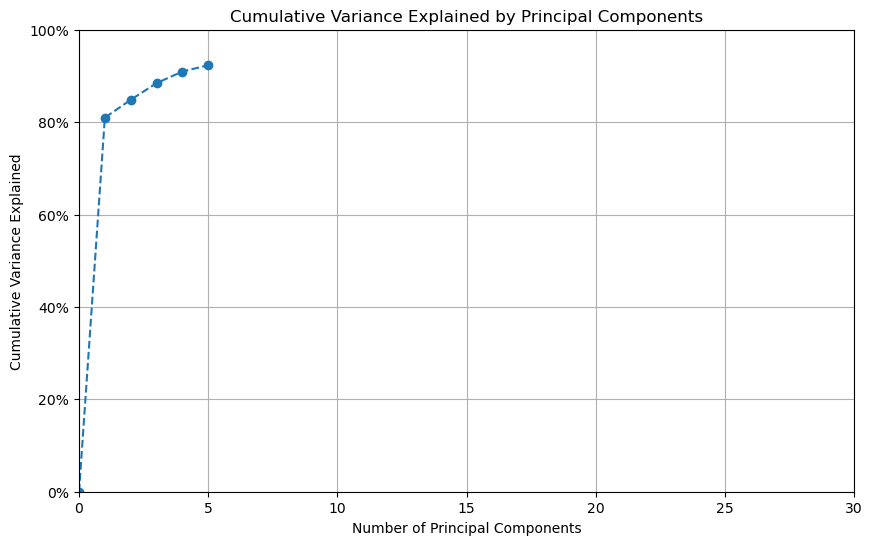

In [172]:
from matplotlib.pyplot import plot


def plot_principal_components_heatmap(principal_components, title="Principal Components Heatmap"):
  plt.figure(figsize=(12, 4))
  sns.heatmap(principal_components, cmap="bwr_r", center=0, xticklabels=Z.columns, yticklabels=[f"PC{i+1}" for i in range(principal_components.shape[0])])
  plt.title(title)
  plt.xlabel("Features")
  plt.ylabel("Principal Components")
  plt.show()

def plot_cumulative_variance_explained(explained_variance_ratio, title="Cumulative Variance Explained by Principal Components"):
  cumulative_variance = np.insert(np.cumsum(explained_variance_ratio), 0, 0)
  plt.figure(figsize=(10, 6))
  plt.plot(range(len(cumulative_variance)), cumulative_variance, marker='o', linestyle='--')
  plt.title(title)
  plt.xlabel("Number of Principal Components")
  plt.ylabel("Cumulative Variance Explained")
  plt.grid(True)
  plt.ylim(0, 1)
  plt.xlim(0, 30)
  plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
  plt.show()

# Example usage
plot_principal_components_heatmap(U.T[:5])
plot_principal_components_heatmap(principal_components)
plot_cumulative_variance_explained(S**2/(S**2).sum())
plot_cumulative_variance_explained(explained_variance_fractions)

The first component is level and explains 81% of variance. The next level roughly corresponds to long size/growth/value, but only contributes 4%.


In [168]:
X_pc = (F_pc, Z.to_numpy())


q2_results, theta_2_hat_iid, iid_result = approach_1_ols(F_pc, Z)
q2_results["1st Stage GMM"] = solve_gmm_identity(X_pc, theta_2_hat_iid)
theta_2_hat_gmm = np.vstack((q2_results["1st Stage GMM"]["b_hat"], q2_results["1st Stage GMM"]["mu_hat"]))
q2_results["2nd Stage GMM"] = solve_gmm_optimal(X_pc, theta_2_hat_gmm)

for name, results in q2_results.items():
  print(
  f"""{'='*30} {name} {'='*(70-len(name))}
  b_hat: {results['b_hat']}
  mu_hat: {results['mu_hat']}
  J: {results['J']:0.5g} Fail to reject null with p={results['p_value']:0.5f}
  square_sharpe: {results['square_sharpe']:0.5g}\n {'='*101}"""
  )


============================== IID ===================================================================
  b_hat: [1.189e-17 5.615e-16 -7.901e-16 6.38e-16 3.787e-16]
  mu_hat: [9.896e-19 2.232e-18 -2.929e-18 1.648e-18 5.293e-19]
  J: 0.20813 Fail to reject null with p=1.00000
  square_sharpe: 0.0010725
============================== 1st Stage GMM =========================================================
  b_hat: [0.1575 1.447 -2.356 1.398 -0.7185]
  mu_hat: [-0.0001021 -0.0009383 0.001527 -0.0009061 0.0004658]
  J: 8.0493e+13 Fail to reject null with p=0.00000
  square_sharpe: 0.00033687
============================== 2nd Stage GMM =========================================================
  b_hat: [0.1575 1.447 -2.356 1.398 -0.7185]
  mu_hat: [-0.0001021 -0.0009383 0.001527 -0.0009061 0.0004658]
  J: 0.98407 Fail to reject null with p=1.00000
  square_sharpe: 0.00033687


In [169]:
X_pc = (F_pc_2, Z.to_numpy())


q2_results, theta_2_hat_iid, iid_result = approach_1_ols(F_pc_2, Z)
q2_results["1st Stage GMM"] = solve_gmm_identity(X_pc, theta_2_hat_iid)
theta_2_hat_gmm = np.vstack((q2_results["1st Stage GMM"]["b_hat"], q2_results["1st Stage GMM"]["mu_hat"]))
q2_results["2nd Stage GMM"] = solve_gmm_optimal(X_pc, theta_2_hat_gmm)

for name, results in q2_results.items():
  print(
  f"""{'='*30} {name} {'='*(70-len(name))}
  b_hat: {results['b_hat']}
  mu_hat: {results['mu_hat']}
  J: {results['J']:0.5g} Fail to reject null with p={results['p_value']:0.5f}
  square_sharpe: {results['square_sharpe']:0.5g}\n {'='*101}"""
  )


============================== IID ===================================================================
  b_hat: [-4.342e-17 8.017e-16 3.524e-16 3.842e-16 -5.145e-16]
  mu_hat: [-3.613e-18 3.188e-18 1.306e-18 9.925e-19 -7.192e-19]
  J: 0.57469 Fail to reject null with p=1.00000
  square_sharpe: 0.00099197
============================== 1st Stage GMM =========================================================
  b_hat: [0.1575 1.447 -2.356 1.398 -0.7185]
  mu_hat: [-0.0001021 -0.0009384 0.001527 -0.0009061 0.0004658]
  J: -3.9296e+14 Fail to reject null with p=1.00000
  square_sharpe: 0.00033687
============================== 2nd Stage GMM =========================================================
  b_hat: [0.1575 1.447 -2.356 1.398 -0.7185]
  mu_hat: [-0.0001047 -0.0009557 0.001561 -0.0009232 0.0004754]
  J: 1.0123 Fail to reject null with p=1.00000
  square_sharpe: 0.00033685


# Q2 Analysis

### Part A

The estimates are similar due to the properties of principal components (PCs). IID estimation and first-stage GMM use the same moment conditions but differ in their weighting matrix as proved in class. Showing that the first N rows of $Ag(\theta)$ are 0 in the IID case, we now want to show that the following $K$ rows are linear combinations of the test assets FOCs. Starting with $A$, given:

$$
d = \begin{pmatrix}
-\beta \Sigma_f & \beta \mu_f b' \\
-\Sigma_f & \mu_f b' \\
0& -I_K
\end{pmatrix}
$$

We can see that the first $N$ rows are linear in $\beta$ to the followng $K$ rows under the null of correct model specification.

Moving to $g(\theta)$, the first $N$ moment conditions, $E[mZ]=0$, and our construction of $F$, $F=GZ$ where $G$ are the eigen vectors of $Z^TZ$, hence $F$ is linear in $Z$. Given that, under the null, $F$ is a correct model specification in both cases, we can expect that the $K$ eigen vectors used fully span $Z$.

In our numerical case, we should expect differences to arise due to idiosyncratic noise on $Z$ conditions and $F$ not fully spanning the test assets due to stopping after the 5th PC.

### Part B

In this case, , the covariance matrix of the moment conditions, was invertible, allowing for a standard second-stage GMM implementation. However, given the factor pricing conditions' structure, is expected to be singular. This singularity arises because the factor pricing conditions should be linear combinations of the test asset pricing conditions, introducing linear dependence and reducing the rank of $g(\theta)$to at most $N+K$. This in turn implies $S = E[g(\theta)'g(\theta)]$ is also not full rank and therefore non-invertible.

Proposed fixes:

(1) Using the pseudo-inverse scales linearly dependent moment conditions based on their magnitude. This effectively reweights the conditions, while allowing the matrix to be inverted and still including the dependent factor pricing conditions.

(2) By removing the factor pricing conditions, we eliminate the source of linear dependence, leaving only the test asset and factor mean moment conditions.
Comparison of Alternatives:

These approaches should yield identical results given that the test assets are linear combinations of the factors.
